### MobileViT Playground
MobileViT Paper: https://arxiv.org/abs/2110.02178 (2021)

DeepLabV3 Paper: https://arxiv.org/abs/1706.05587 (2017)

Moco self-supervised pretraining: https://arxiv.org/abs/1911.05722 (2019)

Goal:

*   Blank MobileViT
*   MobileViT w/ given pretrained weights
*   MobileViT w/ self-supervised pretraining



In [361]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!pip install timm
from tqdm.auto import tqdm
!pip install transformers

In [362]:
import os
from os import listdir, path
import time
import numpy as np
import nibabel as nib #for reading .nii.gz format MRI files
import pylab as plt #use pyplot in matplotlib instead, pylab is about to archived
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import pickle

import torchvision.transforms as trans
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch import from_numpy

import monai
from monai.data import CacheDataset, DataLoader, CSVDataset, Dataset
from monai.data.utils import pad_list_data_collate
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscreted, AsDiscrete,
    Compose,
    LoadImaged, LoadImage,
    SplitDimd,SplitDim,
    Orientationd,
    Randomizable,
    Resized,
    CenterSpatialCropd,
    ScaleIntensityd, ScaleIntensity,
    ScaleIntensityRanged, ScaleIntensityRange,
    Spacingd,
    EnsureTyped,
    ToTensord,
    NormalizeIntensityd, NormalizeIntensity,
    RandSpatialCropd,
    RandRotated,
    RandFlipd,
    RandAdjustContrastd,
    SaveImage
)


%matplotlib inline

In [363]:
# set up model save directory
from google.colab import drive
drive.mount('/content/drive')

#import sys
#sys.path += '/content/drive/MyDrive/harini_lab_memo'
#%cd drive
#%cd MyDrive
#%cd harini_lab_memo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Try Segmentation

### Explore images
ProstateX dataset (cleaned version): https://rcuocolo.github.io/PROSTATEx_masks/

Original version: https://www.cancerimagingarchive.net/collection/prostatex/

In [376]:
os.chdir("/content/drive/MyDrive/harini_lab/")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

/content/drive/MyDrive/harini_lab


In [389]:
# /lesions/ includes Images, Masks, Original_coordinate_markers, && image_list.csv
# /prostate/ includes Images, mask_prostate, mask_pz, mask_tz, && image_list.csv
file_dir = '/content/drive/MyDrive/harini_lab/PROSTATEx/Files/slices_fixed/'
#file_dir2 = file_dir.replace("lesions","prostate")

# check the csv with filed names
csvFilePath = os.path.join(file_dir,'slices_fixed_total.csv')
csvFile = pd.read_csv(csvFilePath) #lesions_total
csvFile.head()

,ID,chID,ADC_image_slice,ADC_mask_slice,ADC_slice_hape
0,ProstateX-0000-Finding1,ProstateX-0000,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,"torch.Size([3, 84, 128])"
1,ProstateX-0001-Finding1,ProstateX-0001,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,"torch.Size([3, 84, 128])"
2,ProstateX-0001-Finding1,ProstateX-0001,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,"torch.Size([3, 84, 128])"
3,ProstateX-0002-Finding1,ProstateX-0002,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,"torch.Size([3, 84, 128])"
4,ProstateX-0002-Finding1,ProstateX-0002,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,/content/drive/MyDrive/harini_lab/PROSTATEx/Fi...,"torch.Size([3, 84, 128])"


(3, 84, 128)
0.0
0.9999999997671694
0.0034722222214137823
0.05882317479914241


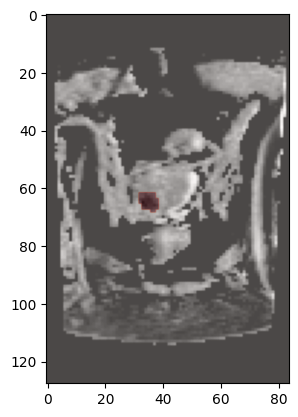

In [393]:
'''
i=1
eximage_path = os.path.join(cwd, csvFile['ADC_image_slice'][i])
exmask_path = os.path.join(cwd, csvFile['ADC_mask_slice'][i])
eximage_a = nib.load(eximage_path)
exmask_a  = nib.load(exmask_path)
eximage = eximage_a.get_fdata()
exmask  = exmask_a.get_fdata()
#print(eximage_a.affine)
#print(eximage_a.header)
print(eximage.shape)
print(exmask.min()); print(exmask.max());print(exmask.mean());print(exmask.std())
print(eximage.min()); print(eximage.max());print(eximage.mean());print(eximage.std())

#eximg.orthoview() #NiBabel viewer not openning
# show the central slice: ex.19//2 = 9   ex.7//2 = 3
plt.imshow(eximage[1,:, :].T, cmap='Greys_r')
plt.imshow(exmask[1,:, :].T,  cmap='Reds', alpha=0.3)
'''

In [ ]:
'''
print(batch_data["image"].affine)
print(batch_data["image"].meta)
print(inputs[0].affine)
print(inputs[0].meta)
image_slices = inputs[j].squeeze(0)
print(image_slices.affine)
print(image_slices.meta)
'''

tensor([[[-2.0000e+00,  4.1021e-10, -8.3267e-17,  9.1534e+01],
         [ 3.9854e-10,  1.9431e+00, -7.1051e-01, -1.4341e+02],
         [ 9.7153e-11,  4.7368e-01,  2.9146e+00, -8.7932e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       dtype=torch.float64)
{'qoffset_z': tensor([-87.9320]), 'dim_info': tensor([54], dtype=torch.uint8), 'quatern_b': tensor([-1.0182e-10]), 'srow_y': tensor([[ 3.9854e-10,  1.9431e+00, -7.1051e-01, -1.4341e+02]]), space: [RAS], 'as_closest_canonical': tensor([False]), 'filename_or_obj': ['PROSTATEx/Files/slices_only/ADC/Images/ProstateX-0002-Finding1_image_slices.nii.gz'], 'intent_p1': tensor([0.]), original_channel_dim: tensor([2]), 'scl_slope': tensor([nan]), 'srow_x': tensor([[-2.0000e+00,  4.1021e-10, -8.3267e-17,  9.1534e+01]]), 'qform_code': tensor([1], dtype=torch.int16), 'pixdim': tensor([[-1.,  2.,  2.,  3.,  1.,  1.,  1.,  1.]]), 'quatern_c': tensor([-0.9929]), 'dim': tensor([[  3,  84, 128,   5,   1,   1,   1,   1]], dtype

#### check data

torch.Size([3, 84, 128])
torch.Size([1, 5, 84, 128])


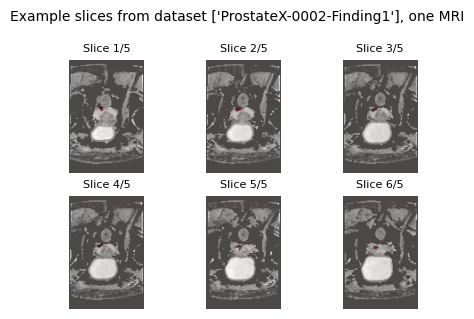

In [ ]:
'''print(inputs[0].squeeze(0).shape)
print(batch_data["image"].shape)
fig = plt.figure(figsize=(5, 5))
for i in range(len(inputs)):
    for j in range(3): #three-channel
        num_slice = (i*3+j)+1
        a = plt.subplot(3, 3, num_slice); a.axis("off"), a.set_title("Slice {}/{}".format(num_slice, batch_data["image"].shape[1]),fontsize=8)
        plt.imshow(inputs[i].squeeze(0)[j,:,:].T, cmap="gray")
        plt.imshow(labels[i].squeeze(0)[j,:,:].T,  cmap='Reds', alpha=0.3)
fig.suptitle("Example slices from dataset {}, one MRI".format(filename),fontsize=10) # batch_size=1
plt.show()
'''

### Put into dataset using MONAI
https://docs.monai.io/en/latest/transforms.html#dictionary-transforms

#### Directory

In [364]:
!nvcc --version
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [365]:
os.chdir("/content/drive/MyDrive/harini_lab/")
cwd = os.getcwd() #/Users/rita/Desktop/
print(cwd)

/content/drive/MyDrive/harini_lab


In [366]:
# load files
file_dir = '/content/drive/MyDrive/harini_lab/PROSTATEx/Files/slices_fixed/'
csvFilePath_total = os.path.join(file_dir,'slices_fixed_total.csv') #lesions_total.csv
csvFilePath_train = os.path.join(file_dir,'slices_train.csv')#lesion_train.csv
csvFilePath_val = os.path.join(file_dir,'slices_val.csv') #lesion_val.csv


In [367]:
'''
#train val split
df = pd.read_csv(csvFilePath_total) #(299,16)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.sort_index()
val_df = val_df.sort_index()

train_df = train_df.rename_axis('original_index')
val_df = val_df.rename_axis('original_index')

train_df.to_csv(csvFilePath_train)
val_df.to_csv(csvFilePath_val)

print(train_df.shape) #(239,16) (418,4)
print(val_df.shape) #(60,16) (105,4)
train_df.head()
'''

"\n#train val split\ndf = pd.read_csv(csvFilePath_total) #(299,16)\n\ntrain_df, val_df = train_test_split(df, test_size=0.2, random_state=42)\ntrain_df = train_df.sort_index()\nval_df = val_df.sort_index()\n\ntrain_df = train_df.rename_axis('original_index')\nval_df = val_df.rename_axis('original_index')\n\ntrain_df.to_csv(csvFilePath_train)\nval_df.to_csv(csvFilePath_val)\n\nprint(train_df.shape) #(239,16) (418,4)\nprint(val_df.shape) #(60,16) (105,4)\ntrain_df.head()\n"

#### Load

In [368]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],channel_dim=0), #default NibelReader #[3, 84, 128]
        EnsureChannelFirstd(keys=["image", "label"]), #[3, 84, 128]
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=3500, b_min=0, b_max=1, clip=True), #ADC

        #spacing? why need? assume has affine in metadata
        # DW sequence: 2 mm in-plane and 3.6 mm slice thickness
        #Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Resized(keys=["image", "label"], spatial_size=(288,288), anti_aliasing=True), #[3, 288, 288]
        CenterSpatialCropd(keys=["image", "label"], roi_size=(256,256)), #[3, 256, 256]
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False), #execute random transforms on GPU directly

        #data augmentations:
        RandRotated(keys=["image", "label"], prob=0.5, range_x=[-1.0, 1.0]), #random rotation
        RandAdjustContrastd(keys=["image"], prob=0.5, gamma=(0.5, 2.0)), #ColorJitter in PyTorch

        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],channel_dim=0), #default NibelReader #[3, 84, 128]
        EnsureChannelFirstd(keys=["image", "label"]), #[3, 84, 128]
        ScaleIntensityRanged(keys=["image"], a_min=0, a_max=3500, b_min=0, b_max=1, clip=True), #ADC

        Resized(keys=["image", "label"], spatial_size=(288,288), anti_aliasing=True), #[3, 288, 288]
        CenterSpatialCropd(keys=["image", "label"], roi_size=(256,256)), #[3, 256, 256]
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False), #execute random transforms on GPU directly
        # without data augmentations
        ToTensord(keys=["image", "label"]),
    ]
)

In [369]:
train_dataset_pre = CSVDataset( #change to CacheDataset for faster later:  train_dataset_pre
    src=csvFilePath_train,
    col_names=["ID","ADC_image_slice", "ADC_mask_slice"],
    col_groups={"image": "ADC_image_slice", "label": "ADC_mask_slice"}, #create new col, easier later switch to T2
    transform=train_transforms,
    # may not need to load so many columns
)
val_dataset = CSVDataset(
    src=csvFilePath_val,
    col_names=["ID","ADC_image_slice", "ADC_mask_slice"],
    col_groups={"image": "ADC_image_slice", "label": "ADC_mask_slice"}, #create new col, easier later switch to T2
    transform=val_transforms,
    # may not need to load so many columns
)

In [ ]:
#train_dataset_pre[1]

In [370]:
train_dataset = CacheDataset(train_dataset_pre, cache_rate=1.0)
#train_dataset = train_dataset_pre

Loading dataset: 100%|██████████| 450/450 [00:43<00:00, 10.23it/s]


In [371]:
train_loader = DataLoader(train_dataset, batch_size=4) #num_workers=0, pin_memory=True)#, collate_fn=pad_list_data_collate) #(239) #still error?? #collate_fn=pad_list_data_collate
val_loader = DataLoader(val_dataset, batch_size=1)  # num_workers=0, pin_memory=True) #(60)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


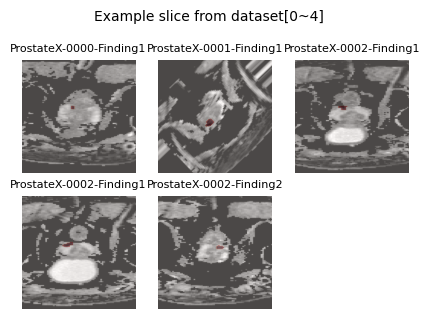

In [394]:
# plot the transformed image array
fig = plt.figure(figsize=(5, 5))
for i in range(5):
    a = plt.subplot(3, 3, i + 1); a.axis("off"); a.set_title(train_dataset[i]["ID"],fontsize=8) #chID
    print(train_dataset[i]["image"].shape)
    plt.imshow(train_dataset[i]["image"].cpu()[0,:,:].T, cmap="gray")
    plt.imshow(train_dataset[i]["label"].cpu()[0,:,:].T,  cmap='Reds', alpha=0.3)
fig.suptitle("Example slice from dataset[0~4]",fontsize=10)
plt.show()

torch.Size([4, 3, 256, 256])
0.0
0.91971105


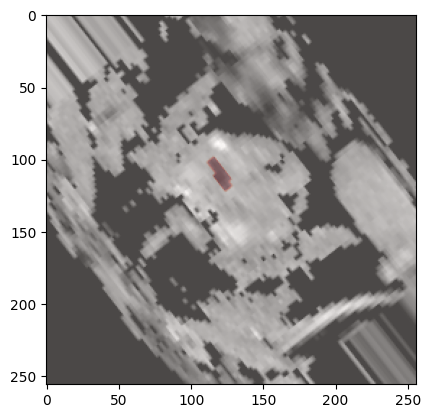

In [397]:
# check image in loader
#batch_data = next(iter(train_loader)) #dictionary object, len=8

i = 0
for batch_data in train_loader:
    i += 1
    if i == 6: #choose to see which example images
        break

#print(batch_data["shape"]) #[84,128,5]'''
input = batch_data["image"]
label = batch_data["label"]
#print(input.shape)
print(input.shape) #[1,5,256,256]
print(np.min(input))
print(np.max(input))

#check
plt.imshow(input[0,1,:,:].cpu().T, cmap="gray") #0,1,2 / 3,4,5 / 6,7
plt.imshow(label[0,1,:,:].cpu().T, cmap= 'Reds', alpha=0.3)

### Try Training
Modify to MONAI / transformer trainer later

MONAI: https://docs.monai.io/en/stable/engines.html#trainer

HF(transformer): https://huggingface.co/docs/transformers/main/en/training#finetune-with-trainer

Reference training loop: https://colab.research.google.com/drive/1ebbMS5qNH0s7grA_cZSTu5MIo7vPXbYC?usp=sharing

#### Define

In [477]:
# Define MobileViT_DeepLabV3 model class
class MobileViT_DeepLabV3(nn.Module):
    def __init__(self, backbone, seg_head):
        super(MobileViT_DeepLabV3, self).__init__()
        self.backbone = backbone
        self.seg_head = seg_head
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_intermediate=False):
        outputs_base = self.backbone(x)
        inputs_seg = outputs_base[-1].to(device) #[batch, 256/512/1024, 8/32, 8/32] feature maps #backprop???
        outputs_seg = self.seg_head(inputs_seg) #[batch, 1, 8/32, 8/32] MetaTensor
        # need softmax(multiclass)/sigmoid(binary) activation to turn feature map into segmentation probability
        outputs_active = self.sigmoid(outputs_seg) #[batch, 1, 32, 32] #ex.max=0.8551, min=0.1949
        #print(f"outputs_active.max(): {outputs_active.max()}")
        #print(f"outputs_active.min(): {outputs_active.min()}")
        #outputs_upsampled = F.interpolate(outputs_active, size=x.shape[-2:], mode='nearest-exact')#'bilinear', align_corners=False) #[batch, 3, 256, 256] #ex. max=0.8345, min=0.2594
        outputs_upsampled = F.interpolate(outputs_active, size=x.shape[-2:], mode='bilinear', align_corners=False) #[batch, 3, 256, 256] #ex. max=0.8345, min=0.2594

        return outputs_upsampled #outputs_upsampled


In [478]:
# Confirm models
base_model = timm.create_model(
    'mobilevitv2_100.cvnets_in1k',
    pretrained=True,
    features_only=True,
    #output_stride=8,
).to(device)

seg_model = DeepLabHead(
    in_channels=512,  # Adjust if feature map from base_model differ
    num_classes=3,  # matching the input channel in mobilevitv2
    atrous_rates=(6,12,18) #from the paper, PyTorch default (12,24,36)
).to(device)

model = MobileViT_DeepLabV3(base_model, seg_model).to(device)

In [479]:
# Define Loss, Optimizer, Scaler
from monai.losses import DiceCELoss
from torch.nn import BCEWithLogitsLoss

torch.backends.cudnn.benchmark = True
#loss_function = BCEWithLogitsLoss()   #nn.CrossEntropyLoss()
loss_function = DiceCELoss(include_background=True, to_onehot_y=False, sigmoid=False, squared_pred=True) #1.0090 #to_onehot_y=True for [batch,1,3,256,256] #sigmoid already in the model? #why use squared_pred in denominator?

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.00005) #lr > weight_decay #as paper, base_model & seg_model? #0.0005
scaler = torch.cuda.amp.GradScaler()

In [480]:
#Define dice metric for evaluation
from monai.metrics import DiceMetric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False) #[batch,1,3,256,256] #The include_background parameter can be set to False to exclude the first category (channel index 0)
discrete_pred = AsDiscrete(to_onehot=None, threshold=0.5)  #should be probability #to_onehot=number of classes, threshold=values
discrete_label = AsDiscrete(to_onehot=None, threshold=0.5) #originally not only [0,1] but PROSTATEx docu said it is binarized, bg=0 always

In [481]:
# evaluation loop
def validation(model, val_loader, dice_metric, device):
    model.eval()

    with torch.no_grad():
        for batch_data in val_loader:
            inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),)# [batch, 3, 256, 256]
            with torch.cuda.amp.autocast():
                outputs_upsampled_v = model(inputs)

                outputs_upsampled_v = outputs_upsampled_v.unsqueeze(1) #[batch,1,3,256,256]
                outputs_upsampled_v = discrete_pred(outputs_upsampled_v)
                labels_v = labels.unsqueeze(1) #[batch,1,3,256,256]
                labels_v = discrete_label(labels_v)
            dice_metric(y_pred=outputs_upsampled_v, y=labels_v) #num_class=shape[1]
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    #print(f"Evaluation finished! Average loss = {avg_loss:2.5f}")
    return mean_dice_val

#validation_loss = validation(model, val_loader, dice_metric, device)
#print(f"Evaluation finished! Average dice metric = {validation_loss:2.5f}")

#### Confirm loss & metric

In [468]:
# check loss again
batch_data = next(iter(train_loader))

model.train()
inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),)
with torch.cuda.amp.autocast():
    outputs_upsampled = model(inputs) #[batch,3,256,256]
    outputs_upsampled = outputs_upsampled.unsqueeze(1) #[batch, 1, 3,256,256]
    print(outputs_upsampled.shape)
    labels = labels.unsqueeze(1) #[batch, 1, 3,256,256]
    print(labels.shape)
    loss = loss_function(outputs_upsampled, labels) #1.9552
print(f"loss: {loss}")

model.eval()
inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),)
with torch.no_grad():
    outputs_upsampled = model(inputs)
    outputs_upsampled_v = outputs_upsampled.unsqueeze(1) #[batch,1,3,256,256]
    outputs_upsampled_v = discrete_pred(outputs_upsampled_v)
    print(outputs_upsampled_v.shape)
    labels_v = labels.unsqueeze(1) #[batch,1,3,256,256]
    labels_v = discrete_label(labels_v)
    print(labels_v.shape)
    dice_metric(y_pred=outputs_upsampled_v, y=labels_v) #num_class=shape[1]
mean_dice_val = dice_metric.aggregate().item() # 0.004
dice_metric.reset()
print(f"mean_dice_val: {mean_dice_val}")


torch.Size([4, 1, 3, 256, 256])
torch.Size([4, 1, 3, 256, 256])
loss: 1.9465646743774414
torch.Size([4, 1, 3, 256, 256])
torch.Size([4, 1, 3, 256, 256])
mean_dice_val: 0.006033625453710556


metatensor(0., device='cuda:0')
metatensor(1., device='cuda:0')
metatensor(0., device='cuda:0')
metatensor(1., device='cuda:0')


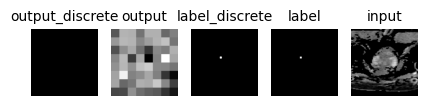

In [469]:
fig = plt.figure(figsize=(5, 5))
a=plt.subplot(2,5,1); a.axis("off"); a.set_title("output_discrete",fontsize=10)
plt.imshow(outputs_upsampled_v[0,0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,2); a.axis("off"); a.set_title("output",fontsize=10)
plt.imshow(outputs_upsampled[0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,3); a.axis("off"); a.set_title("label_discrete",fontsize=10)
plt.imshow(labels_v[0,0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,4); a.axis("off"); a.set_title("label",fontsize=10)
plt.imshow(labels[0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,5); a.axis("off"); a.set_title("input",fontsize=10)
plt.imshow(inputs[0,0,:,:].cpu().T, cmap="gray")
print(outputs_upsampled_v.min())
print(outputs_upsampled_v.max())
print(labels_v.min())
print(labels_v.max())


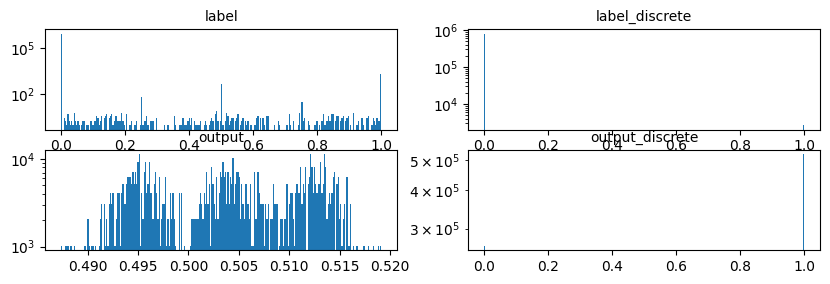

In [470]:
fig = plt.figure(figsize=(10, 6))
a = plt.subplot(4, 2, 1);  a.set_title("label",fontsize=10)
plt.hist(labels.cpu().numpy().flatten(), bins=256, log=True)
a = plt.subplot(4, 2, 2);  a.set_title("label_discrete",fontsize=10)
plt.hist(labels_v.cpu().numpy().flatten(), bins=256, log=True)
a = plt.subplot(4, 2, 3);  a.set_title("output",fontsize=10)
plt.hist(outputs_upsampled.cpu().numpy().flatten(), bins=256, log=True)
a = plt.subplot(4, 2, 4);  a.set_title("output_discrete",fontsize=10)
plt.hist(outputs_upsampled_v.cpu().numpy().flatten(), bins=256, log=True)
plt.show()

#### Train

In [482]:
# saving the model
model_dir = os.path.join(cwd, "model_0716") #/content/drive/MyDrive/harini_lab/model_X
if path.exists(model_dir) == False:
    os.mkdir(model_dir)
    print(f"Create new folder {model_dir}")
model_name = "model_ADC_slice_fixed_diceCE_includeBG_bilinear_interp_50iter.pth"
model_save_dir = os.path.join(model_dir, model_name)
print(model_save_dir)

/content/drive/MyDrive/harini_lab/model_0716/model_ADC_slice_fixed_diceCE_includeBG_bilinear_interp_50iter.pth


In [483]:
# training loop
# 1 iters

def train(model, train_loader, loss_function, optimizer, scaler, device,
          metric_value_best, global_step_best,
          global_step_start, max_epochs, num_example):

    start_time = time.time()

    model.train()

    global_step = global_step_start
    num_example = num_example #the total number of images: 239+60
    ori_resolution = (256, 256)

    print(f"Training starts! Set to run {max_epochs} epochs")
    for epoch in range(global_step_start, max_epochs):
        epoch_loss = 0 # recalculate for each epoch
        for batch_data in train_loader: #239
            optimizer.zero_grad() #at the start
            inputs, labels = (batch_data["image"].to(device),batch_data["label"].to(device),)
            # Forward pass
            with torch.cuda.amp.autocast():
                outputs_upsampled = model(inputs) #[1,3,256,256]
                outputs_upsampled = outputs_upsampled.unsqueeze(1) #[batch, 1, 3,256,256]
                labels = labels.unsqueeze(1) #[batch, 1, 3,256,256]
                loss = loss_function(outputs_upsampled, labels)
            # Backward pass
            scaler.scale(loss).backward()
            #print(loss.item())
            epoch_loss += loss.item()
            #print(epoch_loss)
            scaler.unscale_(optimizer)
            scaler.step(optimizer)
            scaler.update()

        epoch_loss /= num_example #average loss over this epoch
        epoch_loss_values.append(epoch_loss)
        print(f"Training {epoch + 1} epoch (loss={epoch_loss:2.5f})")

        # Validation & Save Model
        if epoch % 10 == 0 or epoch + 1 == max_epochs: #hardcoded to 10 iter, may change later
            # Validation
            mean_dice_val = validation(model, val_loader, dice_metric, device)
            metric_values.append(mean_dice_val)
            # Save Model: best validation loss
            if mean_dice_val > metric_value_best: #using MONAI DiceMetric(): larger, better overlap
                metric_value_best = mean_dice_val
                global_step_best = epoch
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict(),
                    'epoch': epoch,
                    'best_epoch': global_step_best,
                    'epoch_loss_values': epoch_loss_values,
                    'metric_values': metric_values,
                }, model_save_dir)
                print(f"Model saved! Epoch ({epoch + 1} / {max_epochs}). Training loss={epoch_loss:2.5f}, Evaluation dice metric={mean_dice_val:2.5f}")
            else:
                print(f"Model NOT saved! Epoch ({epoch + 1} / {max_epochs}). Training loss={epoch_loss:2.5f}, Evaluation dice metric={mean_dice_val:2.5f}")

        global_step = epoch

    # Temporary:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'epoch': global_step,
        'best_epoch': global_step_best,
        'epoch_loss_values': epoch_loss_values,
        'metric_values': metric_values,
    }, model_save_dir)
    print(f"Model saved! Epoch ({global_step + 1} / {max_epochs}).")


    # Finish Training
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training finished! Total time: {total_time:2.5f} seconds") #CSV dataset: 104sec/epoch; #Cache Dataset rate=1: 50sec/epoch
    return global_step, global_step_best, epoch_loss_values, metric_values, metric_value_best



In [484]:
# Call train(), need to re-Define first
num_example = 418 #523
epoch_loss_values = []
metric_values = []
metric_value_best = 0.0 #using DiceCELoss, change to dicemetric() later????

global_step_best = 0 #change to continue training
global_step = 0 #change to continue training

In [487]:
print(f"global_step: {global_step}, global_step_best: {global_step_best}, metric_value_best: {metric_value_best}")
print(len(epoch_loss_values))
print(len(metric_values))

global_step: 99, global_step_best: 0, metric_value_best: 0.08388669788837433
100
11


In [486]:
# Call train() separately, for continuous training
max_epochs = 100
if global_step > 0:
    global_step+=1  #continue without repeat
global_step, global_step_best, epoch_loss_values, metric_values, metric_value_best = train(model, train_loader, loss_function, optimizer, scaler, device,
                                                                                           metric_value_best, global_step_best,
                                                                                           global_step, max_epochs, num_example)

Training starts! Set to run 100 epochs
Training 1 epoch (loss=0.45940)
Model saved! Epoch (1 / 100). Training loss=0.45940, Evaluation dice metric=0.08389
Training 2 epoch (loss=0.41718)
Training 3 epoch (loss=0.41380)
Training 4 epoch (loss=0.41315)
Training 5 epoch (loss=0.41278)
Training 6 epoch (loss=0.41245)
Training 7 epoch (loss=0.41251)
Training 8 epoch (loss=0.41294)
Training 9 epoch (loss=0.41288)
Training 10 epoch (loss=0.41279)
Training 11 epoch (loss=0.41288)
Model NOT saved! Epoch (11 / 100). Training loss=0.41288, Evaluation dice metric=0.00000
Training 12 epoch (loss=0.41293)
Training 13 epoch (loss=0.41331)
Training 14 epoch (loss=0.41302)
Training 15 epoch (loss=0.41268)
Training 16 epoch (loss=0.41201)
Training 17 epoch (loss=0.41208)
Training 18 epoch (loss=0.40917)
Training 19 epoch (loss=0.41189)
Training 20 epoch (loss=0.41305)
Training 21 epoch (loss=0.41269)
Model NOT saved! Epoch (21 / 100). Training loss=0.41269, Evaluation dice metric=0.00000
Training 22 epo

In [ ]:
'''
# Save the model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scaler_state_dict': scaler.state_dict(),
    'epoch': global_step,
    'best_epoch': global_step_best,
    'epoch_loss_values': epoch_loss_values,
    'metric_values': metric_values,
}, model_save_dir)'''

In [ ]:
'''# Load the model
checkpoint = torch.load(model_save_dir)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])
global_step = checkpoint['epoch']
global_step_best = checkpoint['best_epoch']
epoch_loss_values = checkpoint['epoch_loss_values']
metric_values = checkpoint['metric_values']'''

#### Check training output (val)

In [ ]:
#validation_loss = validation(model, val_loader, loss_function, device)
#print(f"Evaluation finished! Average loss = {validation_loss:2.5f}")

In [ ]:
def test_save(model, test_loader, loss_function, device): #save testing images
    model.eval()
    eval_metrics = [] #using loss for now??

    with torch.no_grad():
        for batch_data in val_loader:
            inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),) #[batch,3,256,256]
            with torch.cuda.amp.autocast():
                outputs_upsampled_v = model(inputs)

                outputs_upsampled_v = outputs_upsampled_v.unsqueeze(1) #[batch,1,3,256,256]
                outputs_upsampled_v = discrete_pred(outputs_upsampled_v)
                labels_v = labels.unsqueeze(1) #[batch,1,3,256,256]
                labels_v = discrete_label(labels_v)

            dice_metric(y_pred=outputs_upsampled_v, y=labels_v) #num_class=shape[1]
            mean_dice_val = dice_metric.aggregate().item()
            dice_metric.reset()
            eval_metrics.append(mean_dice_val)
            #print(f"Validation (loss={metric:2.5f})")
    #print(f"Evaluation finished! Average loss = {avg_loss:2.5f}")
    return eval_metrics

In [499]:
# Example validation image
#model.eval()
model.train()
val_i = 0
for batch_data in train_loader:
    val_i += 1
    if val_i == 10: #change
        break

inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),) #[batch,3,256,256]
outputs_upsampled = model(inputs)

In [495]:

model.eval()
inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device),)
with torch.no_grad():
    outputs_upsampled = model(inputs)
    outputs_upsampled_v = outputs_upsampled.unsqueeze(1) #[batch,1,3,256,256]
    outputs_upsampled_v = discrete_pred(outputs_upsampled_v)
    print(outputs_upsampled_v.shape)
    labels_v = labels.unsqueeze(1) #[batch,1,3,256,256]
    labels_v = discrete_label(labels_v)
    print(labels_v.shape)
    dice_metric(y_pred=outputs_upsampled_v, y=labels_v) #num_class=shape[1]
mean_dice_val = dice_metric.aggregate().item() # 0.004
dice_metric.reset()
print(f"mean_dice_val: {mean_dice_val}")


torch.Size([1, 1, 3, 256, 256])
torch.Size([1, 1, 3, 256, 256])
mean_dice_val: 0.0


metatensor(0., device='cuda:0')
metatensor(0., device='cuda:0')
metatensor(0., device='cuda:0')
metatensor(1., device='cuda:0')


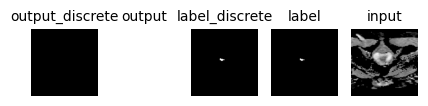

In [496]:
fig = plt.figure(figsize=(5, 5))
a=plt.subplot(2,5,1); a.axis("off"); a.set_title("output_discrete",fontsize=10)
plt.imshow(outputs_upsampled_v[0,0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,2); a.axis("off"); a.set_title("output",fontsize=10)
plt.imshow(outputs_upsampled[0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,3); a.axis("off"); a.set_title("label_discrete",fontsize=10)
plt.imshow(labels_v[0,0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,4); a.axis("off"); a.set_title("label",fontsize=10)
plt.imshow(labels[0,0,:,:].cpu().T, cmap="gray")
a=plt.subplot(2,5,5); a.axis("off"); a.set_title("input",fontsize=10)
plt.imshow(inputs[0,0,:,:].cpu().T, cmap="gray")
print(outputs_upsampled_v.min())
print(outputs_upsampled_v.max())
print(labels_v.min())
print(labels_v.max())


torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 256, 256])


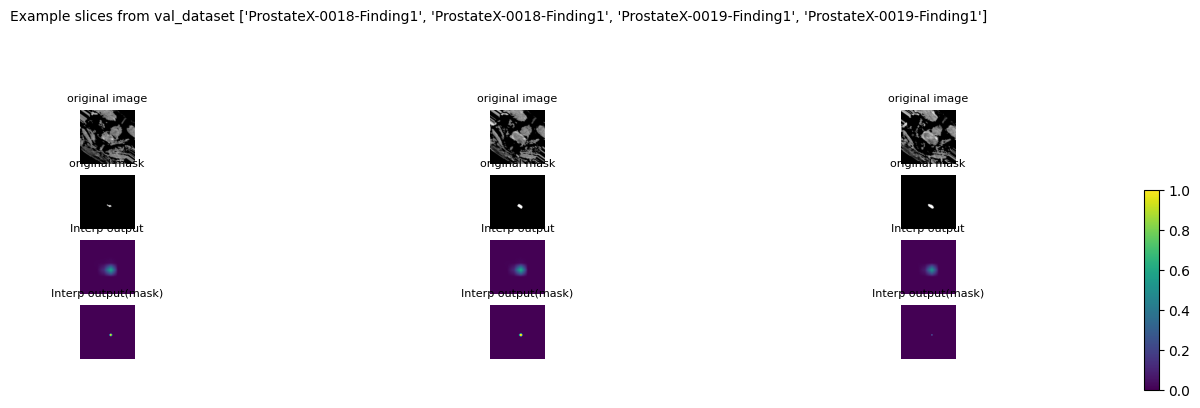

In [500]:
#check
print(batch_data["image"].shape)
print(labels.shape)
print(outputs_upsampled.shape)
results_upsampled = outputs_upsampled.cpu().detach().numpy()
inputs_for_eval = inputs.cpu()
labels_for_eval = labels.cpu()

# Thresholding to get binary mask????
threshold = 0.5
binary_masks = (results_upsampled > threshold) #[6,1,256,256]

fig = plt.figure(figsize=(15, 10))
for j in range(3):
    a = fig.add_subplot(12, 3, j+1); a.set_title("original image", fontsize=8); a.axis("off");
    plt.imshow(inputs_for_eval[0,j,:,:].T, cmap="gray")

    a = fig.add_subplot(12, 3, j+1+3); a.set_title("original mask", fontsize=8);a.axis("off");
    plt.imshow(labels_for_eval[0,j,:,:].T, cmap="gray")

    a = fig.add_subplot(12, 3, j+1+6);a.set_title("Interp output", fontsize=8); a.axis("off");
    imgplot = plt.imshow(results_upsampled[0,j,:,:].T,vmin=0,vmax=1)

    a = fig.add_subplot(12, 3, j+1+9);a.set_title("Interp output(mask)", fontsize=8);a.axis("off");
    plt.imshow(binary_masks[0,j,:,:].T)

fig.suptitle("Example slices from val_dataset {}".format(batch_data["ID"]),fontsize=10)
cbar_ax = fig.add_axes([0.93, 0.6, 0.01, 0.2]) #[right,up,thickness,length]
fig.colorbar(imgplot, cax=cbar_ax)

In [ ]:
#check
print(inputs.max()) #normalized [0,1]
print(inputs.min())

#results_upsampled.max() #-3.0733058: this is a feature map, not probability?
#results_upsampled.min() #-6.5495143
print(results_upsampled.max()) #0.54454064: after applying sigmoid(), it is a probability?
print(results_upsampled.min()) #0.3701884

metatensor(0.7677, device='cuda:0')
metatensor(0., device='cuda:0')
2.3204804e-33
0.0


In [ ]:
# try mean Intersection over Union (mIoU)
# need to handle [nan]
from monai.metrics import compute_iou, DiceMetric
label_for_eval = labels_for_eval[:,0,:,:].unsqueeze(1)
binary_mask = from_numpy(binary_masks)
#iou_metric = compute_iou(binary_mask, label_for_eval)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False) #function
dice_value = dice_metric(binary_mask, label_for_eval)
print(dice_value) #ERROR: nan???

metatensor([[0., 0., nan],
        [0., 0., nan]])


In [ ]:
print(epoch_loss_values)
print(metric_values)

[0.9772365781552622]
[0.005922770127654076]


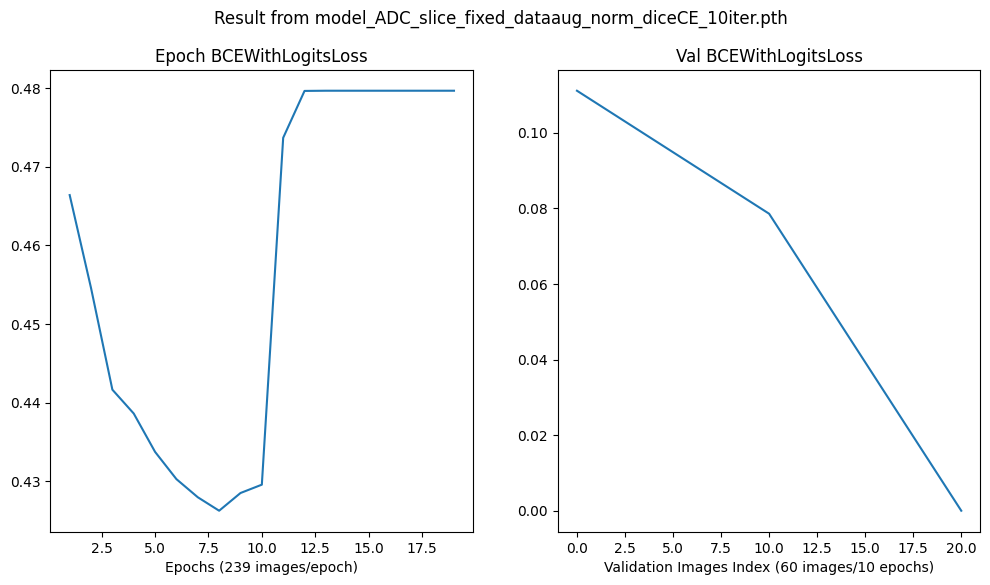

In [ ]:
# Check loss & metrics
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch BCEWithLogitsLoss"); plt.xlabel(f"Epochs ({num_example} images/epoch)")
x = [i+1 for i in range(len(epoch_loss_values))] #239 steps per iter /num_example
y = epoch_loss_values
plt.plot(x, y)

plt.subplot(1, 2, 2)
plt.title("Val BCEWithLogitsLoss"); plt.xlabel("Validation Images Index (/10 epochs)")
x = [(i)*10 for i in range(len(metric_values))]
y = metric_values
plt.plot(x, y)

plt.suptitle(f"Result from {model_name}")
plt.show()

## DeepLabv3-MobileViTv2 w/ given weights?

For segmentation, there are training on 'ADE20K Dataset' & 'Pascal VOC 2012 Dataset' for DeepLabv3 MobileViTv2-1.0

Github: https://github.com/apple/ml-cvnets/blob/main/docs/source/en/general/README-model-zoo.md#pascal-voc-2012-dataset


### Try Custom Head (ignore for now)

In [ ]:
#experiment block (ignore for now)
#https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/deeplabv3.html
import torch
import torch.nn as nn

class DeepLabHeadCustom(nn.Module):
    def __init__(self, in_channels, num_classes=1, atrous_rates):
        atrous_rates = (6, 12, 18)
        out_channels = 256

        super(DeepLabHeadCustom, self).__init__()
        self.aspp = ASPP(in_channels, out_channels, atrous_rates)
        self.classifier = nn.Conv2d(out_channels, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.aspp(x)
        x = self.decoder(x)
        return x

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        self.in_proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        out_proj = nn.Conv2d(5 * out_channels, out_channels, kernel_size=1) #why hard code as 5? num of feature maps??

        modules = [in_proj]
        modules.extend([
          nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[0]),
          nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[1]),
          nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=atrous_rates[2])
        ])
        modules.append(
            ASPPPooling(opts=opts, in_channels=in_channels, out_channels=out_channels)
        )

        self.convs = nn.ModuleList(modules)
        self.project = out_proj

        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.relu(self.batch_norm(self.conv1(x)))
        x2 = self.relu(self.batch_norm(self.conv2(x)))
        x3 = self.relu(self.batch_norm(self.conv3(x)))
        x4 = self.relu(self.batch_norm(self.conv4(x)))

        out = []
        for conv in self.convs:
            out.append(conv(x))
        out = torch.cat(out, dim=1)
        out = self.project(out)
        out = self.dropout_layer(out)
        return out
        #return torch.cat([x1, x2, x3, x4], dim=1)

class ASPPPooling(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = x.shape[-2:]
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)

# Initialize the model
model = DeepLabHeadCustom(in_channels=512, num_classes=1, atrous_rates=(6, 12, 18))

# Example input tensor
input_tensor = torch.randn(6, 512, 32, 32)

# Forward pass
output = model(input_tensor)
print(output.shape)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-3-7dccfbfa3f43>, line 28)

### Try Transformer package?

In [ ]:
class MobileViT_DeepLabV3(nn.Module):
    def __init__(self, backbone, seg_head):
        super(MobileViT_DeepLabV3, self).__init__()
        self.backbone = backbone
        self.seg_head = seg_head
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_intermediate=False):
        outputs_base = self.backbone(x)
        inputs_seg = outputs_base['last_hidden_state'].to(device) #[batch, 256/512/1024, 8/32, 8/32] feature maps #backprop???
        outputs_seg = self.seg_head(inputs_seg) #[batch, 1, 8/32, 8/32] MetaTensor
        # need softmax(multiclass)/sigmoid(binary) activation to turn feature map into segmentation probability
        outputs_active = self.sigmoid(outputs_seg) #[batch, 1, 32, 32] #ex.max=0.8551, min=0.1949
        #print(outputs_active.max())
        #print(outputs_active.min())
        outputs_upsampled = F.interpolate(outputs_active, size=x.shape[-2:], mode='bilinear', align_corners=False) #[6, 1, 256, 256] #ex. max=0.8345, min=0.2594
        # assert(x.shape[-2:]==[256,256])
        # need a way to check outputs_seg, but cannot affect backprop
        #if return_intermediate:
        #    return outputs_upsampled, outputs_seg
        #else:
        return outputs_upsampled #outputs_upsampled

In [ ]:
#https://github.com/huggingface/transformers/blob/main/src/transformers/models/mobilevitv2/modeling_mobilevitv2.py
#https://huggingface.co/docs/transformers/en/model_doc/mobilevitv2

import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, MobileViTV2ForSemanticSegmentation, AutoModel

base_model = AutoModel.from_pretrained("apple/mobilevitv2-1.0-voc-deeplabv3") #MobileViTV2ForSemanticSegmentation
#WARNING:
#Some weights of MobileViTV2ForSemanticSegmentation were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized: ['segmentation_head.aspp.convs.0.convolution.weight', 'segmentation_head.aspp.convs.0.normalization.bias', 'segmentation_head.aspp.convs.0.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.0.normalization.running_mean', 'segmentation_head.aspp.convs.0.normalization.running_var', 'segmentation_head.aspp.convs.0.normalization.weight', 'segmentation_head.aspp.convs.1.convolution.weight', 'segmentation_head.aspp.convs.1.normalization.bias', 'segmentation_head.aspp.convs.1.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.1.normalization.running_mean', 'segmentation_head.aspp.convs.1.normalization.running_var', 'segmentation_head.aspp.convs.1.normalization.weight', 'segmentation_head.aspp.convs.2.convolution.weight', 'segmentation_head.aspp.convs.2.normalization.bias', 'segmentation_head.aspp.convs.2.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.2.normalization.running_mean', 'segmentation_head.aspp.convs.2.normalization.running_var', 'segmentation_head.aspp.convs.2.normalization.weight', 'segmentation_head.aspp.convs.3.convolution.weight', 'segmentation_head.aspp.convs.3.normalization.bias', 'segmentation_head.aspp.convs.3.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.3.normalization.running_mean', 'segmentation_head.aspp.convs.3.normalization.running_var', 'segmentation_head.aspp.convs.3.normalization.weight', 'segmentation_head.aspp.convs.4.conv_1x1.convolution.weight', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.bias', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.running_mean', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.running_var', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.weight', 'segmentation_head.aspp.project.convolution.weight', 'segmentation_head.aspp.project.normalization.bias', 'segmentation_head.aspp.project.normalization.num_batches_tracked', 'segmentation_head.aspp.project.normalization.running_mean', 'segmentation_head.aspp.project.normalization.running_var', 'segmentation_head.aspp.project.normalization.weight', 'segmentation_head.classifier.convolution.bias', 'segmentation_head.classifier.convolution.weight']
#You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

seg_model = DeepLabHead(
    in_channels=512,  # Adjust if feature map from base_model differ
    num_classes=3,  # matching the input channel in mobilevitv2
    atrous_rates=(6,12,18) #from the paper, PyTorch default (12,24,36)
).to(device)

model = MobileViT_DeepLabV3(base_model, seg_model).to(device)

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-voc-deeplabv3")  #apple/mobilevitv2-1.0-imagenet1k-256
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

NameError: name 'Image' is not defined

In [ ]:
print(outputs[-1]) #[1,512,32,32]

tensor([[-7.2801e-02,  8.5267e-02, -2.9638e-02,  6.7401e-02, -8.7815e-02,
          4.0720e-01,  2.9348e-02, -3.2629e-01,  6.1326e-01,  6.2719e-01,
          1.4558e-01, -9.2261e-02, -4.3833e-01, -4.1101e-03,  1.2911e-02,
          8.9667e-02, -5.5024e-01, -1.2729e-01,  8.7860e-02,  1.3362e-02,
         -4.5252e-01,  2.0839e-01, -8.2026e-02,  7.5711e-02, -7.3276e-02,
         -4.2018e-02, -2.5275e-03, -2.7667e-01,  6.6404e-01, -2.8436e-01,
          4.7972e-02,  3.8975e-01, -3.1527e-01,  8.5884e-01,  6.4614e-02,
         -6.3035e-01, -7.2355e-02, -6.2014e-02,  7.2393e-01, -8.0131e-03,
          6.7259e-02, -4.5150e-03, -1.2911e-03,  9.3672e-02,  2.0740e-01,
          2.8714e-02,  5.4417e-01,  9.9893e-02, -3.0579e-01,  8.8153e-01,
         -3.9888e-02,  1.6500e-03,  1.1752e+00,  4.7328e-01,  8.5680e-02,
          4.4898e-02, -5.2006e-01, -4.9137e-01,  6.6981e-02,  7.0853e-01,
         -1.4826e-02, -6.4402e-03, -8.5003e-02, -7.8465e-02,  1.0487e-02,
          7.3618e-02, -8.9106e-02, -4.

### Model tutorials

In [ ]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, MobileViTV2ForSemanticSegmentation, AutoModel

image_processor = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-voc-deeplabv3")  #apple/mobilevitv2-1.0-imagenet1k-256
model = MobileViTV2ForSemanticSegmentation.from_pretrained("apple/mobilevitv2-1.0-voc-deeplabv3")
#WARNING:
#Some weights of MobileViTV2ForSemanticSegmentation were not initialized from the model checkpoint at apple/mobilevitv2-1.0-imagenet1k-256 and are newly initialized: ['segmentation_head.aspp.convs.0.convolution.weight', 'segmentation_head.aspp.convs.0.normalization.bias', 'segmentation_head.aspp.convs.0.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.0.normalization.running_mean', 'segmentation_head.aspp.convs.0.normalization.running_var', 'segmentation_head.aspp.convs.0.normalization.weight', 'segmentation_head.aspp.convs.1.convolution.weight', 'segmentation_head.aspp.convs.1.normalization.bias', 'segmentation_head.aspp.convs.1.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.1.normalization.running_mean', 'segmentation_head.aspp.convs.1.normalization.running_var', 'segmentation_head.aspp.convs.1.normalization.weight', 'segmentation_head.aspp.convs.2.convolution.weight', 'segmentation_head.aspp.convs.2.normalization.bias', 'segmentation_head.aspp.convs.2.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.2.normalization.running_mean', 'segmentation_head.aspp.convs.2.normalization.running_var', 'segmentation_head.aspp.convs.2.normalization.weight', 'segmentation_head.aspp.convs.3.convolution.weight', 'segmentation_head.aspp.convs.3.normalization.bias', 'segmentation_head.aspp.convs.3.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.3.normalization.running_mean', 'segmentation_head.aspp.convs.3.normalization.running_var', 'segmentation_head.aspp.convs.3.normalization.weight', 'segmentation_head.aspp.convs.4.conv_1x1.convolution.weight', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.bias', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.num_batches_tracked', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.running_mean', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.running_var', 'segmentation_head.aspp.convs.4.conv_1x1.normalization.weight', 'segmentation_head.aspp.project.convolution.weight', 'segmentation_head.aspp.project.normalization.bias', 'segmentation_head.aspp.project.normalization.num_batches_tracked', 'segmentation_head.aspp.project.normalization.running_mean', 'segmentation_head.aspp.project.normalization.running_var', 'segmentation_head.aspp.project.normalization.weight', 'segmentation_head.classifier.convolution.bias', 'segmentation_head.classifier.convolution.weight']
#You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# logits are of shape (batch_size, num_labels, height, width)
logits = outputs.logits #[1, 21, 32, 32]
print(logits.shape)

torch.Size([1, 21, 32, 32])


In [ ]:
print(inputs["pixel_values"].max())
print(inputs["pixel_values"].min())

tensor(1.)
tensor(0.)


In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('mobilevit_xxs.cvnets_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
inputs = transforms(img).unsqueeze(0)

output = model(inputs)  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


In [ ]:
print(np.max(img))
print(np.min(img))

print(inputs.max())
print(inputs.min())
print(torch.mean(inputs))
print(torch.std(inputs))

255
0
tensor(1.)
tensor(0.)
tensor(0.6979)
tensor(0.2212)


In [ ]:
print(transforms)

Compose(
    Resize(size=284, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=tensor([0., 0., 0.]), std=tensor([1., 1., 1.]))
)
